<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="right">


# Procesamiento de lenguaje natural


## TP6

### Alumno: Emmanuel Cardozo

Ejercicio
Construir QA Bot basado en el ejemplo del traductor pero con un dataset QA.

Recomendaciones:
- MAX_VOCAB_SIZE = 8000
- max_length ~ 10
- Embeddings 300 Fasttext
- n_units = 128
- LSTM Dropout 0.2
- Epochs 30~50

Preguntas interesantes:
- Do you read?
- Do you have any pet?
- Where are you from?

__IMPORTANTE__: Recuerde para la entrega del ejercicio debe quedar registrado en el colab las preguntas y las respuestas del BOT para que podamos evaluar el desempeño final.

[LINK](http://convai.io/data/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import re

import numpy as np
import pandas as pd

import keras
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from tensorflow.keras.layers import Concatenate
from keras.layers import Bidirectional

### 1 - Datos

Se descarga la carpeta del dataset

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
import sys
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1QPYxMTBSGNmbyGhknznuO3YWLBOJnhUQ&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [4]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f)

In [5]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [6]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()    
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    
    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out
        
        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [7]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento

Se realiza el preprocesamiento necesario para obtener:

- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [8]:
# Defino el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

In [9]:
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario de palabras de entrada:", len(word2idx_inputs))


output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
#Agrego <sos> y <eos> a los textos del tokenizador.
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario de palabras de salida:", len(word2idx_outputs))

tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
)  # Se omiten los simbolos "<" y ">" para que no afectar los delimintadores "<sos>" y "<eos>"
tokenizer.fit_on_texts(["<sos>", "<eos>"] + input_sentences + output_sentences)

input_integer_seq = tokenizer.texts_to_sequences(input_sentences)
output_integer_seq = tokenizer.texts_to_sequences(output_sentences)

output_input_integer_seq = tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx = tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

num_words_output = min(
    len(word2idx) + 1, MAX_VOCAB_SIZE
)  # Se suma 1 por el primer <sos>

Palabras en el vocabulario de palabras de entrada: 1799
Palabras en el vocabulario de palabras de salida: 1806
Palabras en el vocabulario: 2157
Sentencia de entrada más larga: 9
Sentencia de salida más larga: 10


In [10]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
decoder_input_sequences = pad_sequences(
    output_input_integer_seq, maxlen=max_out_len, padding="post"
)

print("Cantidad de rows del dataset:", len(input_integer_seq))
print("encoder_input_sequences shape:", encoder_input_sequences.shape)
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 6033
encoder_input_sequences shape: (6033, 9)
decoder_input_sequences shape: (6033, 10)


In [11]:
from keras.utils.np_utils import to_categorical

In [12]:
decoder_output_sequences = pad_sequences(
    output_integer_seq, maxlen=max_out_len, padding="post"
)
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(6033, 10, 2158)

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores.


Nos declinamos por Glove

In [13]:
base_path = base_path = R"C:\Users\Emmanuel\Desktop\Desafio 6"

In [14]:
embeddings_path = os.path.join(base_path, "gloveembedding.pkl")

if os.access(embeddings_path, os.F_OK) is False:
    url = "https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download"
    gdown.download(url, embeddings_path, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


In [15]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [16]:
model_embeddings = GloveEmbeddings()

Matriz de embedding para las secuencias en inglés.

In [17]:
print("preparing embedding matrix...")
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

nb_words = min(MAX_VOCAB_SIZE, len(word2idx))  # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print("number of null word embeddings:", np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 44


Dimensión de los embeddings de la secuencia en ingles

In [18]:
embedding_matrix.shape

(2157, 50)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [19]:
n_units = 256

encoder_inputs = Input(shape=(max_input_len))

encoder_embedding_layer = Embedding(
    input_dim=nb_words,  # definido en el Tokenizador
    output_dim=embed_dim,  # dimensión de los embeddings utilizados
    input_length=max_input_len,  # máxima sentencia de entrada
    weights=[embedding_matrix],  # matrix de embeddings
    trainable=False,
)

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len))
decoder_embedding_layer = Embedding(
    input_dim=num_words_output, output_dim=n_units, input_length=max_out_len
)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 9, 50)        107850      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 10, 256)      552448      ['input_2[0][0]']                
                                                                                              

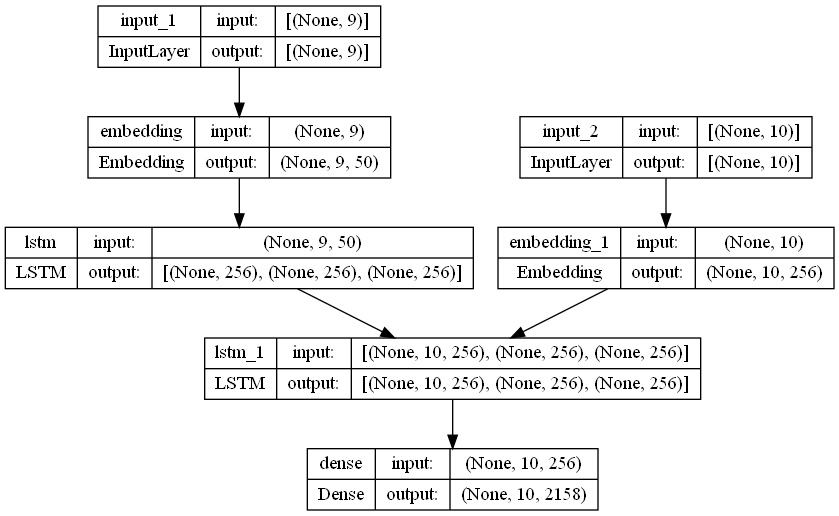

In [20]:
# Modelo completo (encoder+decoder) para poder entrenar
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

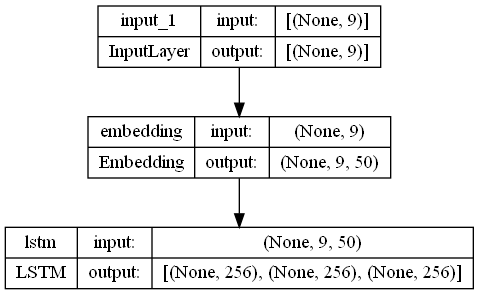

In [21]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

from keras.utils.vis_utils import plot_model
plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

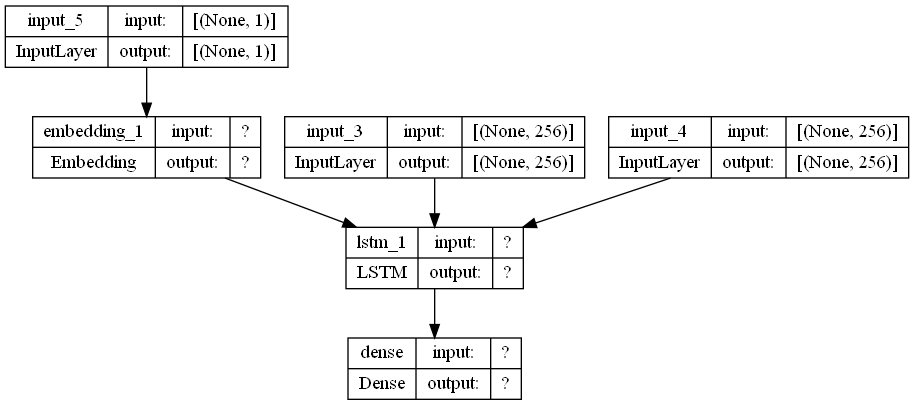

In [22]:
# Modelo solo decoder (para realizar inferencia)
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs_single_x, initial_state=decoder_states_inputs
)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

plot_model(decoder_model, to_file="decoder_plot.png", show_shapes=True, show_layer_names=True)

Entrenamos el modelo encoder_decoder

In [23]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50,
    validation_split=0.2,
)

Epoch 1/50
151/151 [==============================] - 32s 168ms/step - loss: 2.6697 - accuracy: 0.5646 - val_loss: 2.1384 - val_accuracy: 0.6506
Epoch 2/50
151/151 [==============================] - 15s 99ms/step - loss: 1.8053 - accuracy: 0.6843 - val_loss: 1.8717 - val_accuracy: 0.6915
Epoch 3/50
151/151 [==============================] - 15s 101ms/step - loss: 1.5501 - accuracy: 0.7231 - val_loss: 1.7691 - val_accuracy: 0.7075
Epoch 4/50
151/151 [==============================] - 16s 106ms/step - loss: 1.4286 - accuracy: 0.7375 - val_loss: 1.7144 - val_accuracy: 0.7130
Epoch 5/50
151/151 [==============================] - 15s 102ms/step - loss: 1.3496 - accuracy: 0.7431 - val_loss: 1.6843 - val_accuracy: 0.7206
Epoch 6/50
151/151 [==============================] - 16s 103ms/step - loss: 1.2890 - accuracy: 0.7490 - val_loss: 1.6575 - val_accuracy: 0.7246
Epoch 7/50
151/151 [==============================] - 16s 106ms/step - loss: 1.2388 - accuracy: 0.7542 - val_loss: 1.6424 - val_acc

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

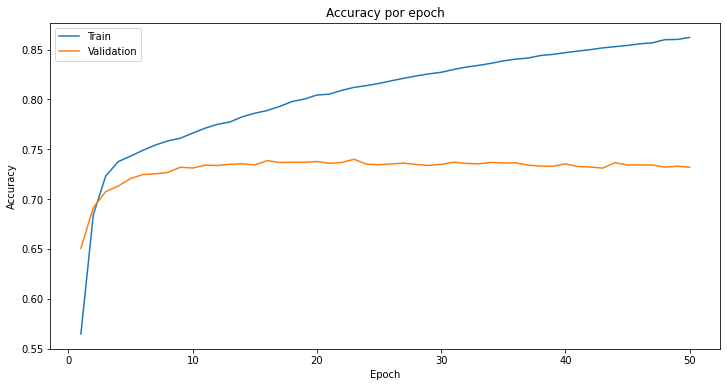

In [25]:
epoch_count = range(1, len(hist.history["accuracy"]) + 1)
plt.figure(figsize=(12, 6))
sns.lineplot(x=epoch_count, y=hist.history["accuracy"], label="Train")
sns.lineplot(x=epoch_count, y=hist.history["val_accuracy"], label="Validation")
plt.title("Accuracy por epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

Definimos una funcion que dado un texto de entrada haga el preprocesamiento necesario y alimente el modelo para obtener una respuesta.

In [26]:
# Conversor de indice a palabra:
idx2word = {v: k for k, v in word2idx.items()}

def get_resp(input_text):
    integer_seq = tokenizer.texts_to_sequences([input_text])[0]
    input_seq = pad_sequences([integer_seq], maxlen=max_input_len)

    # Se transforma la sequencia de entrada a los stados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder"
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx["<sos>"]

    # Se obtiene el indice que finaliza la inferencia
    eos = word2idx["<eos>"]

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ""
        if idx > 0:
            word = idx2word[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la ultima prediccion
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (realimentacion)
        target_seq[0, 0] = idx

    return " ".join(output_sentence)

In [27]:
def chat(input_text):
    response = get_resp(input_text)

    print("Input:", input_text)
    print("Response:", response)

In [28]:
questions = [
    "Do you read?",
    "Do you have any pet?",
    "Where are you from?",
    "How old are you?",
    "How are you?",
    "What do you like to eat",
    "What do you like?",
    "Which sports do you like?",
    "Do you know Argentina?",
]

for question in questions:
    chat(question)
    print("\n")

1/1 [==============================] - 0s 23ms/step
Input: Do you read?
Response: i am not sure what you mean


1/1 [==============================] - 0s 21ms/step
Input: Do you have any pet?
Response: no


1/1 [==============================] - 0s 22ms/step
Input: Where are you from?
Response: i am from the united states


1/1 [==============================] - 0s 20ms/step
Input: How old are you?
Response: i am 32 i am 32


1/1 [==============================] - 0s 21ms/step
Input: How are you?
Response: i am doing well how are you


1/1 [==============================] - 0s 21ms/step
Input: What do you like to eat
Response: i like to read books


1/1 [==============================] - 0s 23ms/step
Input: What do you like?
Response: i like to play video games


1/1 [==============================] - 0s 26ms/step
Input: Which sports do you like?
Response: i like to play video games


1/1 [==============================] - 0s 22ms/step
Input: Do you know Argentina?
Response: i am not s

In [ ]:
import time

user_input = None

while user_input != "":
    user_input = input()
    if user_input != "":
        chat(user_input)
        time.sleep(1)

What do you like to eat?
1/1 [==============================] - 0s 21ms/step
Input: What do you like to eat?
Response: i like to read books
How old are you?
1/1 [==============================] - 0s 21ms/step
Input: How old are you?
Response: i am 32 i am 32
Do you know America?
1/1 [==============================] - 0s 22ms/step
Input: Do you know America?
Response: yes


El bot funciona de manera aceptable para los datos de entrenamiento y la arquitectura sencilla utilizada. 

Si bien no se consiguieron respuestas coherentes en todos los casos, muchas de ellas si lo fueron. Con un mayor dataset de entrenamiento, probablemente se hubiesen conseguido una mejor performance.